In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)

<IPython.core.display.Javascript object>

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# 5 digit classifier
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [9]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0.91125, 0.90855, 0.90915])

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [11]:
y_train_perfect_predictions = y_train_5 # pretend we 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [12]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


* The model correctly predicts 5s 83% of the time
* The model is able to predict only 65% of the 5s

In [13]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [14]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [18]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

<IPython.core.display.Javascript object>

0.9000345901072293

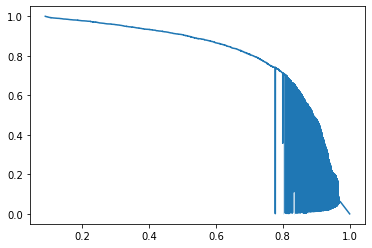

In [19]:
import seaborn as sns
sns.lineplot(precisions, recalls)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

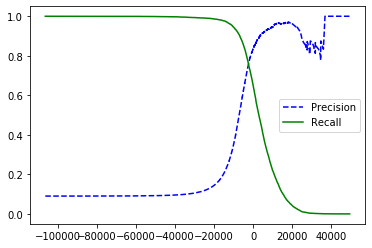

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold and add the legend, axis label, and grid
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.show()

## ROC Curve

In [21]:
y_train_5

array([ True, False, False, ...,  True, False, False])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

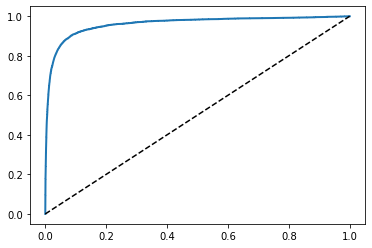

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## MultiClass Classification

In [24]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

In [ ]:
some_digit = X[0]
svm_clf.predict([some_digit])

In [ ]:
svm_digit_scores = svm_clf.decision_function([some_digit])
svm_digit_scores

* Under the hood, svm deploys OVO in training 45 binary classifiers
* For given test images, it predicts using 45 classifiers and picks one that won most duels

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

## MultiLabel Classification

In [7]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

<IPython.core.display.Javascript object>

KNeighborsClassifier()

In [10]:
some_digit = X[0]

In [11]:
knn_clf.predict([some_digit])

array([[False,  True]])

* Metric for multilabel : Consider two labels - Compute F1 score for each and take average
* This weights both the labels equally. But what if one of the label is not imbalanced?
* To correct this, we can use weighted average (each label is weighted by number of instances with that target label)

In [14]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict


y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro') # Considering equal weightage
f1_score(y_multilabel, y_train_knn_pred, average = 'weighted') # Considering weightage based on num of instances

0.9778357403921755

## Multioutput Classification

* This is more like predicting multiple values (>2) for each label in multilabel Classification
* Example : predicting each image pixels in mnist data
* It sound similar to regression of predicting nunmerical values though !

In [16]:
# Create random noise to data and predict the mnist data
noise = np.random.randint(0, 100, (len(X_train)), 784)
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test)), 784)
X_test_mod = X_test + noise

# Predicting images from noisy images
y_train_mod = X_train
y_test_mod = X_test


<IPython.core.display.Javascript object>

TypeError: data type not understood

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod[0])
pl

In [ ]:
plt.imshow(clean_digit, cmap="binary")
plt.axis("off")
plt.show()